In [93]:
import numpy as np
import pulp
import time
from scipy.spatial.distance import cdist

In [94]:
from sklearn.model_selection import train_test_split

from sklearn.datasets import load_iris
data = load_iris()
x_train, x_test, y_train, y_test = train_test_split(
     data.data, data.target, test_size=0.4, random_state=42)

## global variables

In [96]:
gamma = 200
landa = 1.3
error_weight = 0.5

In [97]:
import pulp

In [98]:
def LpMinimizeMultiClassification(x_train,y_train,number_of_class, problem_name = 'Multi classification prob'):
    prob = pulp.LpProblem(problem_name, pulp.LpMaximize)
    v_variables = []
    t_variables = []
    e_variables = []
    p_variables = []
    gg = cdist(x_train,x_train)
    for i in range(len(x_train)+1):
        t = []
        v = []
        for j in range(number_of_class):
            variable = str('t' + str(i)+','+str(j))
            variable = pulp.LpVariable(str(variable))
            t.append(variable)
            variable = str('v' + str(i)+','+str(j))
            variable = pulp.LpVariable(str(variable))
            v.append(variable)
        v_variables.append(v)
        t_variables.append(t)
    
    for i in range(len(x_train)):
        e = []
        p = []
        for j in range(number_of_class):
            variable = str('e' + str(i)+','+str(j))
            variable = pulp.LpVariable(str(variable))
            e.append(variable)
            variable = str('p' + str(i)+','+str(j))
            variable = pulp.LpVariable(str(variable))
            p.append(variable)
        e_variables.append(e)
        p_variables.append(p)
        
#     print(v_variables)      
    optimization_function = ""
    for i in range(int(len(x_train))):
        if i %100  == 0:
            print(i)
        for c in range(number_of_class):
            y = 0
            for j in range(len(x_train)):
                g = np.exp (-gamma*(np.linalg.norm(x_train[i]-x_train[j],2)**2))
                y += v_variables[j][c]*g
            y += v_variables[len(x_train)][c]
            if c == y_train[i]:
                optimization_function += y
            else:
                optimization_function -= y
            optimization_function -= t_variables[i][c]
            optimization_function -= p_variables[i][c]
    prob += optimization_function
    print('constraint')
#     print ("Optimization function: " + str(optimization_function))
    # constraints
    for i in range(int(len(x_train))):
        if i %100  == 0:
            print(i)
        for c in range(number_of_class):
            y = 0
            for j in range(len(x_train)):
                g = np.exp (-gamma*(np.linalg.norm(x_train[i]-x_train[j],2)**2))
                y += v_variables[j][c]*g
            y += v_variables[len(x_train)][c]
            if c == y_train[i]:
                prob += y== 1+e_variables[i][c]
            else:
                prob += y== e_variables[i][c]
            prob += t_variables[i][c] >= landa*v_variables[i][c]
            prob += t_variables[i][c] >= -landa*v_variables[i][c]
            prob += p_variables[i][c] >= e_variables[i][c]
            prob += p_variables[i][c] >= -e_variables[i][c]
#     print(prob)
    print('optimizing')
    start_time = time.time()
    optimization_result = prob.solve()
    print('time:', time.time()-start_time)
    print("Status:", pulp.LpStatus[prob.status])
    # find v values
    result_v = []
    for i in range(len(v_variables)):
        temp = []
        for j in range(len(v_variables[i])):
            temp.append(v_variables[i][j].varValue)
        result_v.append(temp)
    return np.array(result_v)

In [161]:
def calculate_accuracy(x_test,y_test,x_train,v,number_of_class):
    true_predict = 0
    y_label_true = [[],[],[],[],[]]
    y_label_false = [[],[],[],[],[]]
    confusion_matrix = np.zeros((number_of_class,number_of_class))
    for i in range(int(len(x_test))):
        predict_value = []
        for c in range(number_of_class):
            y = 0
            for j in range(len(x_train)):
                g = np.exp (-gamma*(np.linalg.norm(x_test[i]-x_train[j],2)**2))
                y += v[j][c]*g
            y += v[len(x_train)][c]
            predict_value.append(y)
        label = np.argmax(predict_value)
        confusion_matrix[label][int(y_test[i])] +=1
        if label == y_test[i]:
            true_predict += 1
            y_label_true[int(y_test[i])].append(x_test[i].tolist())
        else:
            y_label_false[int(y_test[i])].append(x_test[i].tolist())
    for i in range(number_of_class):
        if len(y_label_true[i])>0:
            d = np.array(y_label_true[i])
            plt.scatter(d[:,0],d[:,1],label = 'true class'+str(i))
        if len(y_label_false[i])>0:
            d = np.array(y_label_false[i])
            plt.scatter(d[:,0],d[:,1],label = 'false class'+str(i),marker='*')
    plt.legend()
    plt.show()
    accuracy = (true_predict/len(x_test))*100
    return accuracy, confusion_matrix

In [151]:
v = LpMinimizeMultiClassification(x_train,y_train,3)

0


KeyboardInterrupt: 

### number of V = 0

In [101]:
np.count_nonzero(v)

92

### Total number of V

In [102]:
len(v)*v.shape[1]

273

### accuracy on train data

In [103]:
import pandas as pd

In [104]:
accuracy,confusion_matrix = calculate_accuracy(x_train,y_train,x_train,v,3)

In [105]:
print('accuracy ',accuracy)

accuracy  100.0


In [106]:
pd.DataFrame(confusion_matrix)

0     1     2
0  27.0   0.0   0.0
1   0.0  31.0   0.0
2   0.0   0.0  32.0

### accuracy on test data

In [108]:
accuracy,confusion_matrix = calculate_accuracy(x_test,y_test,x_train,v,3)

In [109]:
print('accuracy ',accuracy)

accuracy  98.33333333333333


In [110]:
pd.DataFrame(confusion_matrix)

0     1     2
0  23.0   0.0   0.0
1   0.0  19.0   1.0
2   0.0   0.0  17.0

## Other Dataset

In [114]:
import pandas as pd

In [115]:
data = pd.read_excel('5clstrain5000.xlsx')
data = data.get_values()

In [116]:
x_train = data[:,:2]
x_train/=np.max(x_train,axis=0)

In [117]:
y_train  = data[:,-1:]

In [118]:
y_train -= 1

In [119]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.8, random_state=42)

In [120]:
len(x_train)

999

In [121]:
v = LpMinimizeMultiClassification(x_train,y_train,5)

0
100
200
300
400
500
600
700
800
900
constraint
0
100
200
300
400
500
600
700
800
900
optimizing
time: 100.20808291435242
Status: Optimal


In [122]:
v.shape

(1000, 5)

In [123]:
y_train = y_train.reshape(len(y_train))

In [124]:
y_train[0]

2.0

### number of V = 0

In [176]:
v.shape

(1000, 5)

In [177]:
cnt = 0
for i in range(v.shape[0]):
    for j in range(v.shape[1]):
        if v[i][j] == 0:
            cnt +=1
cnt

4689

### Total number of V

In [178]:
np.prod(v.shape)

5000

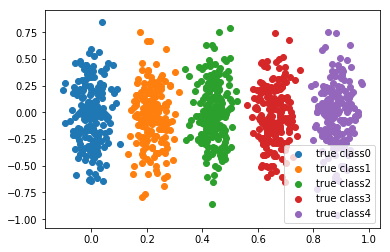

In [163]:
accuracy,confusion_matrix = calculate_accuracy(x_train,y_train,x_train,v,5)

In [164]:
print('accuracy ',accuracy)

accuracy  100.0


In [165]:
pd.DataFrame(confusion_matrix)

0      1      2      3      4
0  190.0    0.0    0.0    0.0    0.0
1    0.0  190.0    0.0    0.0    0.0
2    0.0    0.0  212.0    0.0    0.0
3    0.0    0.0    0.0  204.0    0.0
4    0.0    0.0    0.0    0.0  203.0

In [167]:
len(x_test)

4000

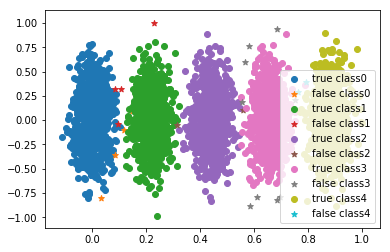

In [168]:
accuracy,confusion_matrix = calculate_accuracy(x_test,y_test,x_train,v,5)

In [169]:
print('accuracy ',accuracy)

accuracy  99.47500000000001


In [170]:
pd.DataFrame(confusion_matrix)

0      1      2      3      4
0  805.0    4.0    0.0    0.0    0.0
1    4.0  806.0    1.0    0.0    0.0
2    0.0    0.0  786.0    6.0    0.0
3    0.0    0.0    1.0  787.0    2.0
4    0.0    0.0    0.0    3.0  795.0

### find data that have V !=0

In [179]:
d = []
for i in range(len(x_train)):
    con = False
    for var in v[i]:
        if var != 0:
            con = True
            break
    if con:
        d.append(x_train[i])
d = np.array(d)

In [180]:
d.shape

(251, 2)

> plot them

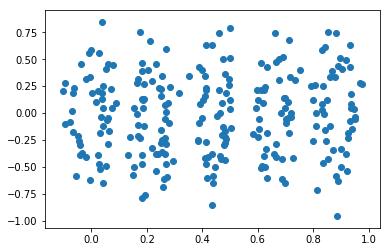

In [181]:
plt.scatter(d[:,0],d[:,1])

In [175]:
pd.DataFrame(v)

0         1             2         3             4
0    0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
1    0.000000 -0.023316  0.000000e+00  0.000000  0.000000e+00
2    0.000000  0.000000  0.000000e+00  0.809988 -1.452368e-02
3    0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
4    0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
5    0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
6    0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
7    0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
8    0.000000  0.000000  0.000000e+00  0.000000 -1.916652e-02
9    0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
10   0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
11   0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
12   0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
13   0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
14   0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
15   0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
16   0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
17   0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
18   0.000000  0.000000  0.000000e+00  0.166728  0.000000e+00
19   1.056688 -0.072253  0.000000e+00  0.000000  0.000000e+00
20   0.278059  0.000000  0.000000e+00  0.000000  0.000000e+00
21   0.000000  0.000000  0.000000e+00 -0.182255  2.534861e-01
22   0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
23   0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
24   0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
25   0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
26   0.000000  0.000000  0.000000e+00  0.000000 -1.514419e-09
27   0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
28   0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
29   0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
..        ...       ...           ...       ...           ...
970  0.000000  0.000000 -2.387466e-02  0.617315  0.000000e+00
971  0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
972  0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
973  0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
974  0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
975  0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
976  0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
977  0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
978  0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
979  0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
980  0.000000  0.000000  9.427172e-01  0.000000  0.000000e+00
981  0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
982  0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
983  0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
984  0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
985  0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
986  0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
987  0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
988  0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
989  0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
990  0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
991  0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
992  0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
993  0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
994  0.000000  0.000000  0.000000e+00 -0.001539  6.058858e-01
995  0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
996  0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
997  0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
998  0.000000  0.000000  0.000000e+00  0.000000  0.000000e+00
999  0.000000  0.000000 -4.312127e-07 -0.005105  2.569284e-09

[1000 rows x 5 columns]